In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.multioutput import MultiOutputRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV, RidgeCV, MultiTaskLassoCV # Ridge и Lasso Регрессия
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import make_scorer, r2_score, precision_score, recall_score, roc_auc_score

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import preprocessing
from sklearn.ensemble import StackingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

import gc

sns.set()
%matplotlib inline

import sys
# np.set_printoptions(suppress=True)
# np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)

DISPLAY_MAX_ROWS = 20 #20
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)
pd.set_option('display.max_column',None)
plt.style.use("seaborn-v0_8-whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [17]:
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
print(X_test.shape)
print(y_test.shape)

(2947, 128, 9)
(2947, 6)


In [18]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
print(X_train.shape)
print(y_train.shape)

(7352, 128, 9)
(7352, 6)


In [19]:
X_concat = np.concatenate((X_train, X_test))
X_concat.shape

(10299, 128, 9)

In [20]:
y_concat = np.concatenate((y_train, y_test))
y_concat.shape

(10299, 6)

In [21]:
y = np.repeat(y_concat, np.repeat(np.array([128]), y_concat.shape[0]), axis=0)
y.shape

(1318272, 6)

In [22]:
x = X_concat.reshape(-1, 9)
x.shape

(1318272, 9)

In [23]:
y

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [24]:
new_y = []
for i in range(len(y)):
  for j in range(len(y[i])):
    if (y[i][j] == 0):
      continue
    else:
      new_y.append(j + 1)

In [25]:
arr1 = np.array([[1, 2, 3], [3, 4, 5]])
arr2 = np.array([6, 7])
arr2 = arr2.reshape(2, 1)
np.concatenate((arr1, arr2), axis = 1)
np.append(arr1, arr2, axis = 1)
arr1

array([[1, 2, 3],
       [3, 4, 5]])

In [27]:
new_y = np.array(new_y)
new_y = new_y.reshape(1318272, 1)
data = np.concatenate((x, new_y), axis = 1)
data

array([[ 1.013, -0.123,  0.103, ...,  0.066,  0.023,  5.   ],
       [ 1.023, -0.127,  0.106, ...,  0.043,  0.01 ,  5.   ],
       [ 1.022, -0.124,  0.102, ...,  0.075,  0.013,  5.   ],
       ...,
       [ 0.919, -0.352, -0.073, ..., -0.021, -0.051,  2.   ],
       [ 0.949, -0.268, -0.051, ..., -0.042, -0.079,  2.   ],
       [ 0.958, -0.194, -0.029, ..., -0.102, -0.046,  2.   ]])

In [28]:
columns = []
for i in range(9):
  columns.append('Sensor {}'.format(i+1))

columns.append('Mode')
columns

['Sensor 1',
 'Sensor 2',
 'Sensor 3',
 'Sensor 4',
 'Sensor 5',
 'Sensor 6',
 'Sensor 7',
 'Sensor 8',
 'Sensor 9',
 'Mode']

In [32]:
df = pd.DataFrame(data, columns = columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318272 entries, 0 to 1318271
Data columns (total 10 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Sensor 1  1318272 non-null  float64
 1   Sensor 2  1318272 non-null  float64
 2   Sensor 3  1318272 non-null  float64
 3   Sensor 4  1318272 non-null  float64
 4   Sensor 5  1318272 non-null  float64
 5   Sensor 6  1318272 non-null  float64
 6   Sensor 7  1318272 non-null  float64
 7   Sensor 8  1318272 non-null  float64
 8   Sensor 9  1318272 non-null  float64
 9   Mode      1318272 non-null  float64
dtypes: float64(10)
memory usage: 100.6 MB


In [34]:
df.describe()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Mode
count,1.318272e+06,1.318272e+06,1.318272e+06,1.318272e+06,1.318272e+06,1.318272e+06,1.318272e+06,1.318272e+06,1.318272e+06,1.318272e+06
mean,8.083301e-01,2.177181e-02,8.483052e-02,-6.653325e-04,-3.175073e-04,-2.039500e-04,-3.411295e-03,-1.716060e-04,8.960282e-04,3.624624e+00
std,4.119907e-01,3.972846e-01,3.442544e-01,1.918905e-01,1.219082e-01,1.037597e-01,4.039425e-01,3.704799e-01,2.539519e-01,1.743611e+00
min,-4.665558e-01,-1.588211e+00,-1.639609e+00,-1.232238e+00,-1.345267e+00,-1.364707e+00,-4.733656e+00,-5.974330e+00,-2.763014e+00,1.000000e+00
25%,6.833297e-01,-2.233207e-01,-1.187414e-01,-3.136368e-02,-1.113368e-02,-1.567600e-02,-5.222125e-02,-5.714719e-02,-2.665964e-02,2.000000e+00
50%,9.570616e-01,-8.275427e-02,4.167499e-02,-7.346850e-04,7.445771e-04,1.527163e-04,-6.013321e-05,-7.037987e-04,5.741191e-04,4.000000e+00
75%,1.019457e+00,1.762589e-01,2.283584e-01,7.486018e-03,2.333138e-02,1.618820e-02,5.490499e-02,3.839570e-02,5.212627e-02,5.000000e+00
max,2.197618e+00,1.217350e+00,1.281363e+00,1.299912e+00,9.759764e-01,1.066916e+00,4.155473e+00,5.746062e+00,2.365982e+00,6.000000e+00


<Axes: ylabel='Frequency'>

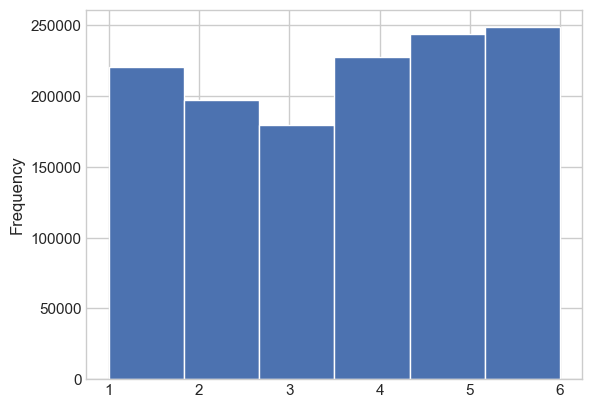

In [35]:
df['Mode'].plot.hist(bins=6)

In [36]:
df['Mode'].value_counts()

Mode
6.0    248832
5.0    243968
4.0    227456
1.0    220416
2.0    197632
3.0    179968
Name: count, dtype: int64

In [37]:
X = df.iloc[:, :9].values
y = df['Mode'].values.astype(int)
y

array([5, 5, 5, ..., 2, 2, 2])

In [38]:
X = SelectKBest(k=7).fit_transform(X, y)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1054617, 7)
(263655, 7)
(1054617,)
(263655,)


In [51]:
# Дерево решений
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [44]:
y_pred = classifier.predict(X_test)
y_pred

array([2, 6, 5, ..., 5, 4, 6])

In [47]:
print('Тренировочные: {}'.format(classifier.score(X_train, y_train)))
print('Тестовые: {}'.format(classifier.score(X_test, y_test)))
print(y_pred.shape)
print(y_test.shape)
print(y_pred)
print(y_test)

Тренировочные: 1.0
Тестовые: 0.9496918321291081
(263655,)
(263655,)
[2 6 5 ... 5 4 6]
[2 6 5 ... 5 4 6]


In [48]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class='ovr')
print('Точность: {}'.format(precision))
print('Полнота: {}'.format(recall))
print('ROC_AUC: {}'.format(roc_auc))

Точность: 0.9452606541685009
Полнота: 0.9449169499829456
ROC_AUC: 0.9674981916928332


In [52]:
# KNN
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [53]:
y_pred = classifier.predict(X_test)
y_pred

array([1, 6, 5, ..., 5, 4, 6])

In [54]:
print('Тренировочные: {}'.format(classifier.score(X_train, y_train)))
print('Тестовые: {}'.format(classifier.score(X_test, y_test)))
print(y_pred.shape)
print(y_test.shape)
print(y_pred)
print(y_test)

Тренировочные: 0.9295440904138659
Тестовые: 0.8997705334622897
(263655,)
(263655,)
[1 6 5 ... 5 4 6]
[2 6 5 ... 5 4 6]


In [55]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class='ovr')
print('Точность: {}'.format(precision))
print('Полнота: {}'.format(recall))
print('ROC_AUC: {}'.format(roc_auc))

Точность: 0.8932640081649897
Полнота: 0.8879966197246012
ROC_AUC: 0.9810189624457394


In [56]:
# GradientBoostingClassifier
classifier = GradientBoostingClassifier(max_depth=6, n_estimators=20,random_state=12, learning_rate=1)
classifier.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1, max_depth=6, n_estimators=20,
                           random_state=12)

In [57]:
classifier.score(X_test, y_test)

0.758677059035482

In [58]:
y_pred = classifier.predict(X_test)
y_pred

array([3, 6, 5, ..., 5, 4, 6])

In [60]:
print('Тренировочные: {}'.format(classifier.score(X_train, y_train)))
print('Тестовые: {}'.format(classifier.score(X_test, y_test)))
print(y_pred.shape)
print(y_test.shape)
print(y_pred)
print(y_test)

Тренировочные: 0.7654266904478119
Тестовые: 0.758677059035482
(263655,)
(263655,)
[3 6 5 ... 5 4 6]
[2 6 5 ... 5 4 6]


In [61]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class='ovr')
print('Точность: {}'.format(precision))
print('Полнота: {}'.format(recall))
print('ROC_AUC: {}'.format(roc_auc))

Точность: 0.7392733501521406
Полнота: 0.7419326147242038
ROC_AUC: 0.860345513106329
